## Fundamental of Machine Learning for Data Analytics Group Assignment

### CS985/6 Spotify Classification Problem 2024

## 1. Introduction 

In the realm of machine learning, classification is a supervised learning approach focused on predicting labels for new data by learning patterns from pre-labelled datasets. In the domain of music streaming services, such as Spotify, classification plays a crucial role in categorizing songs into genres. This is essential for enhancing user experience by providing personalized music recommendations. The challenge of this project lies in leveraging machine learning to predict a song's genre using Spotify's data, which includes attributes like tempo and energy. Despite the subjective nature of musical genres, the goal is to develop an accurate model for genre prediction, ultimately improving content organization and user discovery on streaming platforms.

The notebook is created on Jupyter Notebook with the following detail:
- Python version 3.10.9 | packaged by Anaconda, Inc.
- Jupyter version 6.5.2

In [1]:
# For handling data
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For feature transformation and scaling 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# For fine-tune model
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# Upload data
data_train = pd.read_csv('CS98XClassificationTrain.csv')
data_test = pd.read_csv('CS98XClassificationTest.csv')

## 2. Exploratory Data Analysis

Take a look at dataset

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   year       453 non-null    int64 
 4   bpm        453 non-null    int64 
 5   nrgy       453 non-null    int64 
 6   dnce       453 non-null    int64 
 7   dB         453 non-null    int64 
 8   live       453 non-null    int64 
 9   val        453 non-null    int64 
 10  dur        453 non-null    int64 
 11  acous      453 non-null    int64 
 12  spch       453 non-null    int64 
 13  pop        453 non-null    int64 
 14  top genre  438 non-null    object
dtypes: int64(12), object(3)
memory usage: 53.2+ KB


The train dataset has 453 rows and 14 columns. Among these columns, there are 3 categorical variables, namely title, artist and the target variable "top genre":
- "title" column has 451 unique values, which will be dropped as it might not support to predict genre of the song. We have tried applying tfidf to vectorize title based on text but it did not improve the performance of model.
- "artist" column consists of 345 unique values. Generally, a singer typically focuses on specific music genres that align with their strengths or suit their vocal range and singing style. Therefore, we will encode "artist" variable and then use Princial Component Analysis to reduce the number of dimensions that results from encoding.
- There are 86 unique values in "top genre" column, that refers to multiclass classification. It's noted that 15 out of 86 genre classes account for nearly 70% of the observations in the dataset. Meanwhile, other genres have frequencies below 6, that might be difficult to predict because of the small number of observations. Therefore, we will group the music genres to focus on predicting groups with high frequencies. Details of the grouping method will be detailed below.

In [4]:
len(data_train['title'].unique())

451

In [5]:
len(data_train['artist'].value_counts())

345

In [6]:
# Check the distribution of top genre
data_train['top genre'].value_counts()

top genre
adult standards       68
album rock            66
dance pop             61
brill building pop    16
glam rock             16
                      ..
bow pop                1
australian rock        1
boogaloo               1
british comedy         1
alternative rock       1
Name: count, Length: 86, dtype: int64

In [7]:
# Drop unused column
data_train.drop(['Id', 'title'], axis = 1, inplace = True)

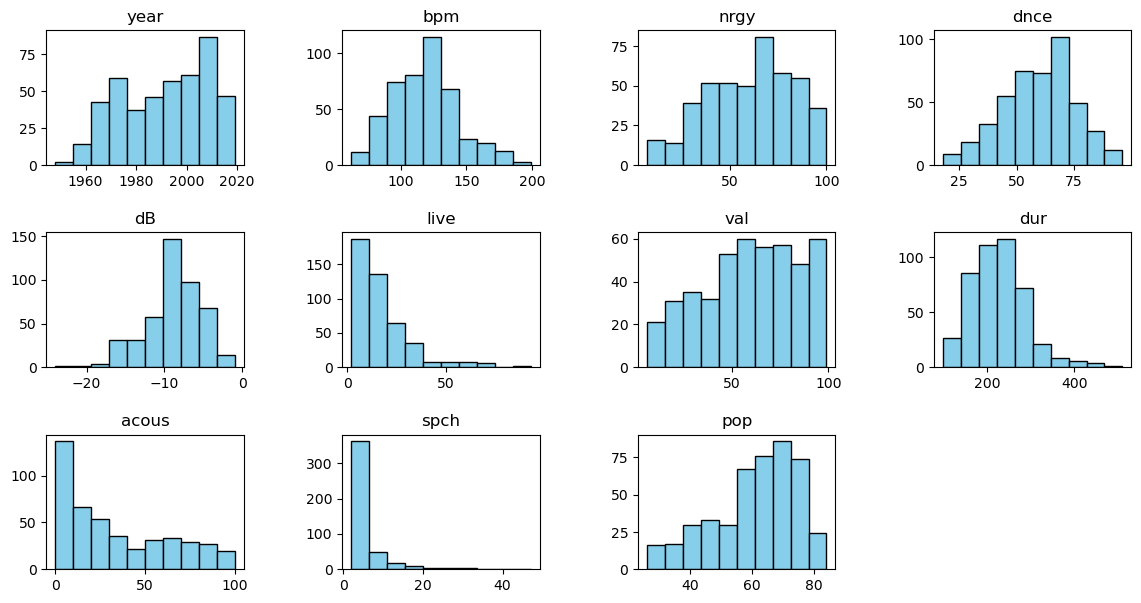

In [8]:
# Plot histograms
fig, axs = plt.subplots((len(data_train.drop(['top genre', 'artist'], axis=1).columns) - 1) // 4 + 1, 4, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for ax, col in zip(axs.flatten(), data_train.drop(['top genre', 'artist'], axis=1).columns):
    ax.histplot(data_train[col], bins=10, color='skyblue', edgecolor='black', kde = True)
    ax.set_title(col)
# Hide any empty subplots
for ax in axs.flatten()[len(data_train.drop(['top genre', 'artist'], axis=1).columns):]:
    ax.axis('off')

A histogram was plotted for all the features to visualize the distribution of the data.
- Year presents a bimodal distribution.
- Liveness, duration, acousticness and speechiness data are right-skewed.
- Popularity data is slightly left skewed.

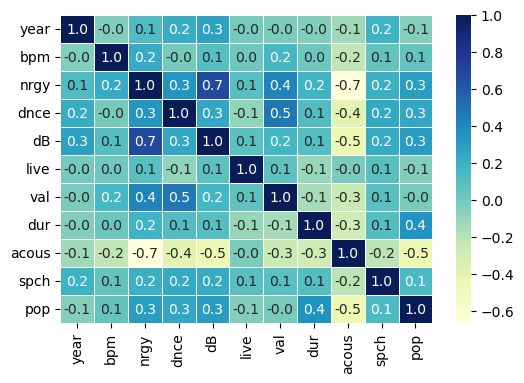

In [9]:
# Check correlation
plt.figure(figsize=(6,4))
sns.heatmap(data_train.drop(['top genre', 'artist'], axis =1).corr(), annot= True,fmt=".1f", cmap ='YlGnBu', linewidth = 0.5)
plt.show()

- Moderate positive correlation between the features: Energy and loudness, Valence and danceability, Energy and valence
- Weak positive correlation between the features: Energy and danceability, Energy and popularity
- Moderate negative correlation between the features: Energy and acousticness, Loudness and acousticness, Acousticness and popularity


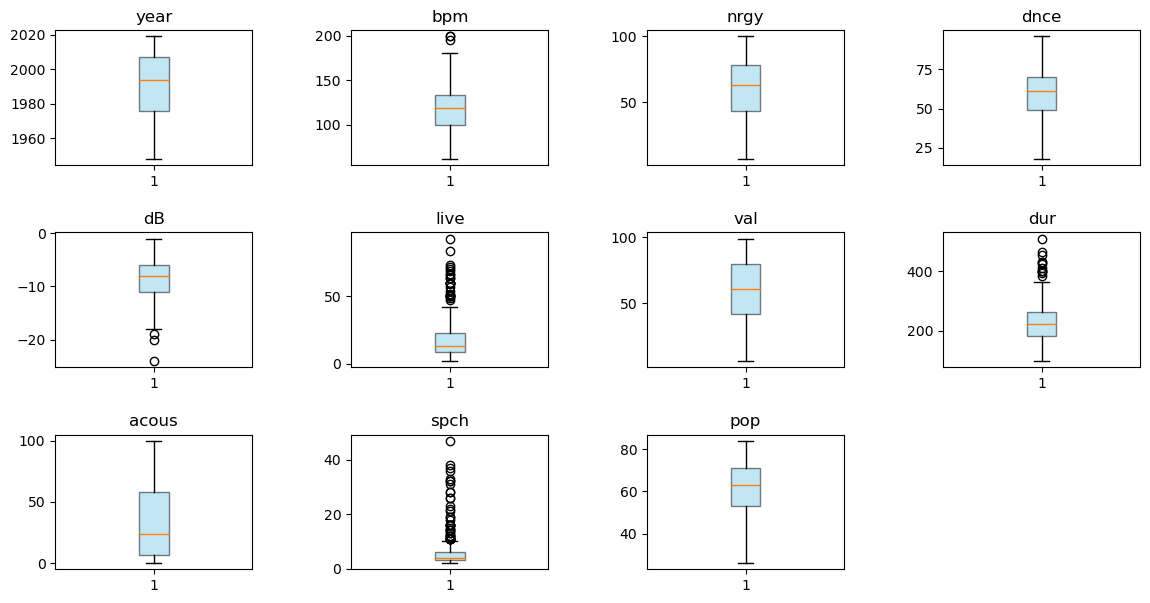

In [10]:
# Plot boxplot to check outliers
fig, axs = plt.subplots((len(data_train.drop(['top genre', 'artist'], axis=1).columns) - 1) // 4 + 1, 4, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for ax, col in zip(axs.flatten(), data_train.drop(['top genre', 'artist'], axis=1).columns):
    ax.boxplot(data_train[col], boxprops = dict(facecolor="skyblue", edgecolor="black", alpha=0.5), patch_artist=True)
    ax.set_title(col)
# Hide any empty subplots
for ax in axs.flatten()[len(data_train.drop(['top genre', 'artist'], axis=1).columns):]:
    ax.axis('off')

The attributes liveness, duration and speechness have outliers. No outliers were removed because we have a small dataset and consider important to keep as many instances as possible.

In the train data, the years of the songs presented had a range of 71 years going from 1948 to 2019. As the range of years presented in data is too wide in proportion to the data size (15.7%) , grouping the years into meaningful categoriels (decades ) provide better information for building the model.

For modeling purposes, it is desirable to work with normally distributed curves. Our data has non-normal properties that we should approximate to a normal curve. 
- For the attributes "speechiness," "liveness," and "duration," which have positive values, the Box-Cox transformation was applied to transforms data so it resembles a normal distribution.
- For the feature ‘acousticnness’ presented zero values, Yeo-Johnson transformation was used as Box-Cox transformation requires data to be strictly positive.

Finally, in order to have data with similar scaling and making it suitable for modeling, all numerical features were scaled using ‘StandardScaler’ from scikit-learn library.

In [11]:
# Check null values
data_train.isna().sum()

artist        0
year          0
bpm           0
nrgy          0
dnce          0
dB            0
live          0
val           0
dur           0
acous         0
spch          0
pop           0
top genre    15
dtype: int64

There are 15 null values in "top genre" variable. Because of the small size of dataset, we will fill null values with most frequent class to keep observation as many as possible.

In [12]:
#Check duplicated values
data_train.duplicated().sum()

1

## 3. Preprocessing

### 3.1 Cleaning data

In [13]:
# Fill null value in top genre with the mode and drop duplicates
mode_genre = data_train['top genre'].value_counts().index[0]
data_train= data_train.fillna(mode_genre)
data_train.drop_duplicates(inplace = True)
data_train.reset_index(drop=True, inplace = True)

In [14]:
# Filtering atributes
atributes = data_train.drop('top genre', axis =1)

### 3.2 Transformation Pipeline

In [15]:
# Make boxcox and yeo johnson transformation
boxcox = PowerTransformer(method = 'box-cox', standardize = False)
yeo_johnson = PowerTransformer(method = 'yeo-johnson', standardize = False)

# Make box cox and yeo johnson pipeline for spch, live,dur and acous
box_pipeline = make_pipeline(boxcox, StandardScaler())
yeo_pipeline = make_pipeline(yeo_johnson, StandardScaler())

# Make a default num piple to standard scaling the remaining columns
default_num_pipeline = StandardScaler()

# Make year pipeline
year_transformer = FunctionTransformer(lambda X: (np.floor(X/10)*10).astype('category'), feature_names_out =  'one-to-one')
year_pipeline = make_pipeline(year_transformer, OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))

# Make artist pipeline
artist_pipeline = make_pipeline(OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), 
                                PCA(n_components = 0.95, random_state = 42))

preprocessing = ColumnTransformer([
    ('boxcox',box_pipeline, ['spch', 'live', 'dur']),
    ('yeo_johnson',yeo_pipeline, ['acous']),
    ('decade', year_pipeline, ['year']),
    ('reduced', artist_pipeline, ['artist'])
], remainder = default_num_pipeline)

In [16]:
atributes = data_train.drop('top genre', axis =1)
X_train = pd.DataFrame(preprocessing.fit_transform(atributes), columns = preprocessing.get_feature_names_out())

After fitting and transfoming train dataset, the same techniques were applied in transforming test dataset.

In [17]:
test_atributes = data_test.drop(['Id', 'title'], axis = 1)
X_test = pd.DataFrame(preprocessing.transform(test_atributes), columns = preprocessing.get_feature_names_out())

### 3.3 Group target classes

The idea to group classes here is vectorizing each class based on the numerical features and then computing their cosine similarities with top 15 most frequent classes. Consequently, the class with highest similarity will be grouped into top 15 most frequent classes and replaced in target variable.

In [18]:
def GenreGroup(df, n_group = 15):
    num_scale = X_train[['boxcox__spch', 'boxcox__live', 'boxcox__dur', 'yeo_johnson__acous','remainder__bpm', 
                         'remainder__nrgy', 'remainder__dnce', 'remainder__dB','remainder__val', 'remainder__pop']] 
    music_features = pd.concat([num_scale, df['top genre']], axis = 1)
    feature_mean = []
    for i in df['top genre'].value_counts().index:
        feature_mean.append(np.mean(music_features[music_features['top genre']==i].drop('top genre', axis=1), axis = 0))
    
    high_genre = data_train['top genre'].value_counts().index[:n_group]
    low_genre =  data_train['top genre'].value_counts().index[n_group:]
    
    feature_df = pd.DataFrame(feature_mean)
    cosine_similarities = cosine_similarity(feature_df.iloc[-len(low_genre):], feature_df.iloc[:-len(low_genre)])
    
    # Assign each input string to the label of the most similar standard string
    labels = {}
    for i, input_string in enumerate(low_genre):
        most_similar_standard_index = cosine_similarities[i].argmax()
        most_similar_standard_string = high_genre[most_similar_standard_index]
        if most_similar_standard_string not in labels:
            labels[most_similar_standard_string] = []
        labels[most_similar_standard_string].append(input_string)
    y_train = data_train['top genre']
    for i in labels.keys():
        y_train = y_train.replace(labels[i], i)
    return y_train

y_train = GenreGroup(data_train, n_group = 15)

## 4. Training Models

For classification task, we trained and fine-tuned hyperparameters of 6 classifiers, namely Logistic Regression, Linear Support Vector Machine, Random Forest, Gradient Boosting, XGBoosting, and Voting Classifiers. All these models were evaluated using 5-fold cross-validation and accuracy ratio.

### 4.1 Logistic Regression

Logistic Regression is a machine learning algorithm which calculates a weighted sum of attributes with a bias term and its output would be the logistic of the final result. In this model, the feature selection was performed using recursive feature elimination. Firstly, the model will be built based on the full set of input variables, and then the least important variables will be removed after each iteration. This process will be repeated until the optimal number of variables is reached. Specifically, in our logistic model, 176 columns were retained to build the model. In addition, we also fine tuned the hyperparameter C with 2 values of 0.1 and 1 for regularization and choose "lbfgs" solver to optimize model as it can handle multinomial loss in multiclass classification.

In [19]:
log =LogisticRegression()
rfecv = RFECV(estimator=log, scoring='accuracy')
param_grid = {'estimator__C': [0.1, 1], 'estimator__solver': ['lbfgs'] }
grid_log = GridSearchCV(estimator=rfecv, param_grid=param_grid, scoring='accuracy', cv=5)
# Fit grid search to training data
grid_log.fit(X_train, y_train)
# Get the best estimator from grid search
best_log = grid_log.best_estimator_
# Get selected feature indices
selected_feature_indices = best_log.get_support(indices=True)

In [20]:
print(len(selected_feature_indices))
print(grid_log.best_params_)

176
{'estimator__C': 1, 'estimator__solver': 'lbfgs'}


In [21]:
# Best accuracy in cross validation
valid_log = grid_log.best_score_
y_pred_log = best_log.predict(X_test)

### 4.2 Linear Support Vector Machine

Linear Support Vector Machine is a algorithm that find the best boundary to divide data into different classes. In this model, we fine-tuned the hyperparameter C for regularization with 3 values, including 1, 10 and 100. As the dataset is high-dimensional with over 300 columns after transformation and has a small size of 453 observations, SVM would be an approriate approach as it can perform well in handling high-dimensional and small datasets.

In [22]:
svm_class = LinearSVC(random_state=42)
param_grid = {'C': [1,10,100]}
grid_svm = GridSearchCV(svm_class,param_grid,cv=5,scoring='accuracy')
grid_svm.fit(X_train, y_train)
grid_svm.best_params_

{'C': 1}

In [23]:
valid_svm = grid_svm.best_score_
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

### 4.3 Ensemble Methods

#### 4.3.1 Random Forest

Random Forest is an ensemble method with Decision Tree technique as a base predictor. It fits a number of decision trees on many sub-samples of the dataset to improve the accuracy and control over-fitting. Another advantage of random forest is handling noisy data and outliers, which would be approriate for this dataset as there are many outliers in "dur", "live", "spch" variables. In this model, the hyperparameters which were fine-tuned are max features, the number of estimators and max leaf nodes.

In [24]:
forest_class = RandomForestClassifier(random_state=42)
param_grid = {
    'max_features':[5,10,15,20,25],
    'n_estimators': [50,100,150,200,250],
    'max_leaf_nodes': [4,8,12,16,18]}
grid_rf = GridSearchCV(forest_class,param_grid,cv=5,scoring='accuracy')
grid_rf.fit(X_train, y_train)
grid_rf.best_params_

{'max_features': 25, 'max_leaf_nodes': 18, 'n_estimators': 200}

In [25]:
valid_rf = grid_rf.best_score_
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

In [30]:
feature_importance_rf = best_rf.feature_importances_.round(2)
feature_names = X_train.columns
# Sort feature importances and feature names together
sorted_features_rf = sorted(zip(feature_importance_rf, feature_names), reverse=True)
# Print the sorted features
print('Top 10 most important features')
for importance, feature_name in sorted_features_rf[:10]:
    print(f"Feature: {feature_name}, Importance: {importance}")

Top 10 most important features
Feature: yeo_johnson__acous, Importance: 0.06
Feature: remainder__nrgy, Importance: 0.05
Feature: boxcox__dur, Importance: 0.05
Feature: remainder__pop, Importance: 0.03
Feature: remainder__dnce, Importance: 0.03
Feature: remainder__dB, Importance: 0.03
Feature: reduced__pca3, Importance: 0.03
Feature: reduced__pca2, Importance: 0.03
Feature: reduced__pca7, Importance: 0.02
Feature: reduced__pca6, Importance: 0.02


#### 4.3.2 Gradient Boosting

Gradient Boosting is a machine learning algorithm that works by iteratively adding predictors to correct the errors of previous predictions. This method attempts to fit the new prediction to the residual of the predecessor. Genarally, gradient boosting is more robust than Ada Boosting as it updates the weight based on gradients, which are less sensitive to outliers. The hyperparameter fine-tuned in this technique are maximum depth of the individual regression estimators, that limit the number of nodes in the tree, number of estimators and learning rate.

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=42)
param_grid = {'max_depth':[2,6], 'n_estimators': [100,200], 'learning_rate': [0.1,0.2]}
grid_gb = GridSearchCV(gbrt, param_grid,cv=5,scoring='accuracy')
grid_gb.fit(X_train, y_train)
grid_gb.best_params_

{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}

In [31]:
valid_gb = grid_gb.best_score_
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)

In [32]:
feature_importance_gb = best_gb.feature_importances_.round(2)
feature_names = X_train.columns
# Sort feature importances and feature names together
sorted_features_gb = sorted(zip(feature_importance_gb, feature_names), reverse=True)
# Print the sorted features
print('Top 10 most important features')
for importance, feature_name in sorted_features_gb[:10]:
    print(f"Feature: {feature_name}, Importance: {importance}")

Top 10 most important features
Feature: remainder__nrgy, Importance: 0.06
Feature: boxcox__dur, Importance: 0.04
Feature: remainder__dB, Importance: 0.03
Feature: reduced__pca2, Importance: 0.03
Feature: yeo_johnson__acous, Importance: 0.02
Feature: remainder__val, Importance: 0.02
Feature: reduced__pca7, Importance: 0.02
Feature: reduced__pca3, Importance: 0.02
Feature: reduced__pca270, Importance: 0.02
Feature: reduced__pca250, Importance: 0.02


#### 4.3.3 XGBoosting

XGBoost includes different regularization penalties to avoid overfitting. Penalty regularizations produce successful training so the model can generalize adequately. Therefore, the model is chosen to use for data training.

In [34]:
le = LabelEncoder()
y_train_label = le.fit_transform(y_train)
params = {"colsample_bytree": uniform(0.7, 0.3), "gamma": uniform(0, 0.5), "learning_rate": uniform(0.03, 0.3), 
          "max_depth": randint(2, 6), "n_estimators": randint(100, 150)}

xgb_model = XGBClassifier(objective='multi:softprob',random_state = 42, n_jobs = -1)
          
rnd_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter = 10, 
                                cv = 5, scoring ='accuracy', random_state=42)
rnd_search.fit(X_train, y_train_label)
rnd_search.best_params_

{'colsample_bytree': 0.981565812704725,
 'gamma': 0.00038938292050716417,
 'learning_rate': 0.3276634677873652,
 'max_depth': 2,
 'n_estimators': 111}

In [35]:
valid_xgb = rnd_search.best_score_
best_xgb = rnd_search.best_estimator_
y_pred_xgb = le.inverse_transform(best_xgb.predict(X_test))

#### 4.3.4 Voting

After training 5 above classifiers, voting classifiers will be trained based on these 5 predictors. We tried 2 types of voting classifiers, namely hard voting and soft voting. In hard voting, the predicted output class is the class with highest majority of votes while soft voting used the average probabilities of the classes to determine which one will be the final prediction. The final result showed that hard voting performed better than soft voting.

In [36]:
params = {'voting': ['hard', 'soft']}
voting_class = VotingClassifier(estimators=[('rf', best_rf), ('gb', best_gb), ('xgb', best_xgb), 
                                            ('svm', best_svm), ('logit', log)], n_jobs=-1)
grid_voting = GridSearchCV(voting_class, params, cv = 5, scoring = 'accuracy')
grid_voting.fit(X_train, y_train)
grid_voting.best_params_

{'voting': 'hard'}

In [37]:
valid_voting = grid_voting.best_score_
best_voting = grid_voting.best_estimator_
y_pred_voting = best_voting.predict(X_test)

## 5. Model Comparison & Selection

Among 6 classifiers built, Linear SVC and Voting Classifier performed best in 5-fold cross-validation with the accuracy ratio of about 60.84% in both models. Meanwhile, the accuracy of other models ranged from about 48% to 54%. It is expected that using above weak classifiers in voting can improve the performance. However, the accuracy ratio of voting classifier was the same as Linear SVC. Based on these validation results, we choose the prediction of test data from Linear SVC and Voting CLassifier to upload on Kaggle. 

In [38]:
accuracy_results = {
    'Logistic Regression': valid_log,
    'Linear SVC': valid_svm,
    'Random Forest': valid_rf,
    'Gradient Boosting': valid_gb,
    'XGBoosting': valid_xgb,
    'Voting': valid_voting
}
# Convert the dictionary into a pandas DataFrame
results_df = pd.DataFrame.from_dict(accuracy_results, orient='index', columns=['Accuracy_Validation'])
# Display the results as a table
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
                     Accuracy_Validation
Logistic Regression             0.513187
Linear SVC                      0.608449
Random Forest                   0.486691
Gradient Boosting               0.533309
XGBoosting                      0.539902
Voting                          0.608425


## 6. Conclusion

The results of predictions from both models submitted on Kaggle are 51.79%, which is out of our expectation as our models just focus on predicting 15 classes with the most frenquencies in data train. The reason implied under these results might be because all these 15 classes also contribute a large proportion of test dataset. Beside, we also tried grouping 20 classes in train dataset with the expectation that our model can learn to predict more classes and improve the accuracy score. However, this grouping did not improve model's performance.

Regarding feature importance, the results from Random Forest and Gradient Boosting are litte different, however there are several variables, which appeared in the top 10 features of both models, namely acoustic, energy, duration and loudness. Therefore, further exploration that we recommend is using these important features to predict music genres and inspect the influences of these factors on predicting type of music. Besides, as the small size of dataset prevented us from predicting more classes in dataset, collecting more data might help improve the performance, especially to predict genres with low frequencies in this dataset.